In [1]:
#keras_timeseries.py
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten    
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
#from keras import backend as K

df = pd.read_csv("customers_timeseries_updated.csv")
#df = pd.read_csv("data-1000customers.csv")
#df = pd.read_csv("100_timeseries_checking_to_share.csv")
#print (df.columns.values)
#df = df.iloc[:,0:3]
#use column names
df = df[['client_debtor_number','dates','fv_cost']]
#print("new dataset columns ",df.columns.values)
#df.head()
# number of customers
len(df['client_debtor_number'].unique())

Using TensorFlow backend.
/Users/anusha/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


101

In [2]:
df_1015130 = df[df['client_debtor_number'] == 1015193]
del df_1015130['client_debtor_number']


In [3]:
#df[df.Date.str.match(r'^2018-06')]
#df[df[\"col\"].str.contains('this|that')==False]
# splitting train and test datasets 
#training 2010-2017, testing on 2018 data\
train_x = df_1015130[df_1015130['dates'].str.contains('/2018') == False]
test_x = df_1015130[df_1015130['dates'].str.contains('/2018') == True]
#print(test_x.dates)
train_x_cust = train_x['fv_cost']
test_x_cust = test_x['fv_cost']

print("train_data ",train_x_cust)
print("test_data ", test_x_cust)

train_data  0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
5           0.000000
6           0.000000
7           0.000000
8           0.000000
9           0.000000
10          0.000000
11          0.000000
12          0.000000
13          0.000000
14          0.000000
15          0.000000
16          0.000000
17          0.000000
18          0.000000
19          0.000000
20          0.000000
21          0.000000
22          0.000000
23          0.000000
24          0.000000
25          0.000000
26          0.000000
27          0.000000
28          0.000000
29          0.000000
             ...    
307581    190.301116
307582    193.302938
307583    196.305162
307584    197.021261
307585    199.928856
307586    191.000154
307587    194.007212
307588    194.524591
307589    197.375700
307590    200.080716
307591     61.073114
307592     62.782689
307593     64.492494
307594     66.202527
307595     67.912788
307596     67.921500
3

http://drivendata.co/blog/benchmark-cold-start-lstm-deep-learning/

In [4]:
train_x['fv_cost'].describe()

count    3192.000000
mean       91.482684
std       170.405114
min      -156.842600
25%         0.000000
50%         0.000000
75%       113.278646
max       813.317904
Name: fv_cost, dtype: float64

In [5]:
#print (train_x[train_x['fv_cost'].str.contains(2016)])
n_input = 2016

train_x[(train_x == n_input).any(1)].stack()[lambda x: x != n_input].unique()

array([], dtype=object)

In [36]:

def lag_feature(df, lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=['fv_cost'])
    
    def rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.fv_cost.shift(i).pipe(rename_lag, i))

    df.dropna(inplace=True)
    return df


#lagged_data=pd.DataFrame(lag_feature(train_x_cust))

# X, y format taking the first column (original time series) to be the y
#X = lagged_data.drop('fv_cost', axis=1).values
#y = lagged_data.fv_cost.values

#train_x_cust = lagged_data[:,0]
#train_y_cust = lagged_data[:,1]




def prepare_training_data(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cost_vals = scaler.fit_transform(series_data.values.reshape(-1, 1))
    
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

train_x_cust,train_y_cust, scalar_train = prepare_training_data(train_x['fv_cost'], 3)
test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_x['fv_cost'], 3)
print(train_x_cust.shape)
print(train_y_cust.shape)


(3189, 1, 3)
(3189,)


In [183]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag =  3

# model parameters
num_neurons = 50 #24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)
dropout_rate =0.2
# instantiate a sequential model
model = Sequential()

#add convolution layer

#Convolution2D (https://keras.io/layers/convolutional/) expects the input to be in the format (samples, rows, cols, channels), 
#which is "channels-last". data is in the format (samples, channels, rows, cols). You should be able to fix
#this using the optional keyword data_format = 'channels_first' when declaring the Convolution2D layer else use
# input_shape=(3,1).
# when strides>1 you cannot have dilation>1
#activation_func = ['softmax', 'softplus', 'softsign', 'relu', 
#                   'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
model.add(Conv1D(filters=num_neurons,batch_size=1, kernel_size=3,
                 strides=3, 
                 padding="same",activation='linear',dilation_rate=1, 
                 input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(dropout_rate))
#model.add(Flatten()) # as flatten is converting data into 1D but we need 3D for our 3lags data here
model.add(Conv1D(filters=num_neurons,batch_size=1, kernel_size=3,
                 strides=3, 
                 padding="same",activation='linear',dilation_rate=1, 
                 input_shape=(1,3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
#model.add(Dropout(dropout_rate))
# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))




# followed by a dense layer with a single output for regression
model.add(Dense(16,activation='linear'))
#model.add(Dense(18,activation='exponential'))
model.add(Dense(1,activation='linear'))
# we can add dropoutlayer after dense as well again
# compile
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#optimizer = Adam(lr=0.001, decay=0.0001)
#model.add(Dropout(dropout_rate))
from keras import optimizers
adam = optimizers.Adam(lr=0.01, decay=0.01)
model.compile(loss='mean_squared_error', optimizer=adam)

%%time
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Learning Consumption Trends - Epoch'):
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in consumption_train.groupby('series_id'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()

In [184]:
from matplotlib import pyplot
model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
# plot metrics
#pyplot.plot(history.history['mse'])
#pyplot.show()

Epoch 1/10
 - 51s - loss: 0.0302
Epoch 2/10
 - 45s - loss: 0.0171
Epoch 3/10
 - 42s - loss: 0.0166
Epoch 4/10
 - 40s - loss: 0.0160
Epoch 5/10
 - 40s - loss: 0.0158
Epoch 6/10
 - 41s - loss: 0.0159
Epoch 7/10
 - 42s - loss: 0.0160
Epoch 8/10
 - 42s - loss: 0.0159
Epoch 9/10
 - 41s - loss: 0.0154
Epoch 10/10
 - 40s - loss: 0.0152


In [185]:

# Estimate model performance
# default batch size is 32 so we need to give batch size explicitly if we want different batch size or 
# input size should be divisible by batch size for stateful LSTM
trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

print('unscaled test score %f MSE' %(scalar_test.inverse_transform(testScore)))
yhat_act_test = scalar_test.inverse_transform(testScore)
yhat_act_train = scalar_train.inverse_transform(trainScore)
#print (math.sqrt(scaler.inverse_transform(testScore)))
#print ("actual train mean_squared_error ",mean_squared_error(test_x.fv_cost[-(len(yhat_act_test)):], yhat_act_test))
print ("actual test rmse ",sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act_test)):], yhat_act_test)))
print ("actual train rmse ",sqrt(mean_squared_error(train_x.fv_cost[-(len(yhat_act_train)):],yhat_act_train)))
#scaler.inverse_transform(testScore)

Train Score: 0.01 MSE (0.12 RMSE)
Test Score: 0.08 MSE (0.29 RMSE)
unscaled test score 723.721271 MSE
actual test rmse  58.019325062682924
actual train rmse  46.77313460672218


Gridsearch CV experiement

In [17]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Function to create model, required for KerasRegressor
def create_model(optimizer='adam',strides_num =3,kernel_size =3,num_neurons=1,
                 activation_func ='relu',dropout_rate = 0.2):
    lag =  3
    num_neurons = 24
    batch_size = 1  # this forces the lstm to step through each time-step one at a time
    batch_input_shape=(batch_size, 1, lag)
    model = Sequential()
    model.add(Conv1D(filters=num_neurons,batch_size=1, kernel_size=kernel_size, strides=strides_num, 
                     padding="same",activation=activation_func,dilation_rate=1, input_shape=(1, 3),
                     data_format='channels_first'))
    model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))

    # followed by a dense layer with a single output for regression
    model.add(Dense(1))
    # we can add dropoutlayer after dense as well again
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model


model = KerasRegressor(build_fn=create_model, verbose=2,batch_size = 1,epochs=5)


In [19]:
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#activation_func = ['softmax', 'softplus', 'softsign', 'relu', 
#                   'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
activation_func = ['softmax', 'relu', 
                   'tanh', 'sigmoid', 'linear']
#param_grid = dict(optimizer=optimizer,activation_func = activation_func)
param_grid = dict(activation_func = activation_func)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(train_x_cust, train_y_cust)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 

#FORECAST BIAS
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]
bias = sum(forecast_errors) * 1.0/len(expected)
print('Bias: %f' % bias)

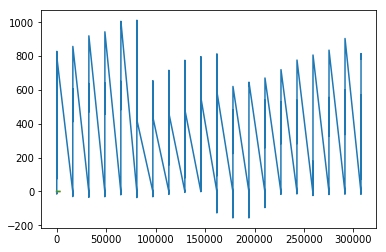

In [10]:
# generate predictions for training
trainPredict = model.predict(train_x_cust,batch_size=1)
testPredict = model.predict(test_x_cust,batch_size=1)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_1015130)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_1015130)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(lag*2)+1:len(df_1015130)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(df_1015130['fv_cost'])
plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot)
plt.show()

In [11]:
# inverse scaling for a forecasted value
cust_id = "100019"
#y_inv = invert_scale(scaler, test_x_cust, testPredict)
yhat_act = scalar_test.inverse_transform(testPredict)
rmse = sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act)):], yhat_act))
print(cust_id," Test RMSE: ",rmse)

100019  Test RMSE:  212.9444811085056


In [12]:
# write predictions into csv
result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
#result_prediction['dates'] = test_x['dates']
result_prediction['original_fv'] = test_y_cust
result_prediction['prediction_fv'] = testPredict

result_prediction.to_csv("predictions_for_client_1015193.csv")

Extra code

In [13]:
scalar_test.inverse_transform(test_y_cust)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.97603556 -0.9636714  -0.95130559 -0.93893812 -0.926569    0.29031932
  0.30811978  0.33047664  0.34872278  0.37122721  0.39373465  0.4162451
  0.27148751  0.29163079  0.31006937 -0.91419823 -0.91419823 -0.92099454
 -0.91649766 -0.90316826 -0.88983707 -0.8765041  -0.86316935 -0.84983281
 -0.8364945   0.33027681  0.35048694  0.37069978  0.39091532  0.41003305
  0.43029187  0.45040125  0.46849455  0.48864712  0.50880238 -0.83230612
 -0.82476944 -0.81169946 -0.79862774 -0.78555427 -0.77431324 -0.76117315
 -0.74803129 -0.73488769 -0.72174232  0.52896034  0.54717047  0.56718363
  0.58719947  0.60721799  0.62723918  0.64726305  0.66728959  0.68731881
  0.70735071 -0.7085952  -0.69544632 -0.68229568 -0.66914328 -0.66025761
 -0.80006778 -0.78735201 -0.77903696 -0.76616627 -0.75329386  0.70735071
  0.68027303  0.65163377  0.67179156  0.69195205  0.71211523  0.72563466
  0.74513523  0.76506493  0.78279628 -0.74041972 -0.72854548 -0.71572565
 -0.70290411 -0.69008085 -0.67725588 -0.6644292  -0.6516008  -0.63950436
 -0.62702743  0.80280707  0.82282053  0.84283667  0.86285549  0.88287698
  0.90290115  0.92292799  0.93954273  0.95969246  0.97984488 -0.61757033
 -0.60457919 -0.59158632 -0.57859171 -0.56559536 -0.57103134 -0.55880759
 -0.54677236 -0.53460875 -0.52244351  1.         -0.86533623 -0.67184821
 -0.85834319 -0.85357313 -0.84348874 -0.90140748 -0.8919321  -0.88245545
 -0.87297753 -0.51027665 -0.49810815 -0.49810815 -0.49489926 -0.49489926
 -0.53045552 -0.51788665 -0.50369568 -0.49488413 -0.48100629 -0.86349835
 -0.8643023  -0.85446661 -0.88832708 -0.87698477 -0.86717734 -0.8558912
 -0.84570406 -0.83437702 -0.82304846 -0.4671266  -0.45324505 -0.45006504
 -0.43799064 -0.42591463 -0.413837   -0.40175775 -0.3896769  -0.37759442
 -0.36551033 -0.81171839 -0.80148732 -0.79048318 -0.78251285 -0.77100867
 -0.75950296 -0.74799571 -0.76498895 -0.75910082 -0.74936347 -0.35342463
 -0.34133731 -0.32924837 -0.31715782 -0.30506565 -0.29297187 -0.2852789
 -0.27321403 -0.26114755 -0.24907945 -0.73962482 -0.72988487 -0.72014361
 -0.71552323 -0.70560308 -0.70008402 -0.69000969 -0.68402206 -0.2417036
 -0.42860998 -0.41686305 -0.41686305 -0.40998507 -0.39810499 -0.38622333
 -0.38622333 -0.45876064 -0.45876064 -0.44641151 -0.43153505 -0.41665661
 -0.41665661 -0.42090721 -0.40536633 -0.38982338 -0.37427835 -0.35873124
 -0.34391572 -0.3283392  -0.3127606  -0.29717992 -0.28159715 -0.26640711
 -0.25083336 -0.28019197 -0.26423943 -0.25843251 -0.24212643 -0.22581818
 -0.20950775 -0.21140346 -0.20063254 -0.1834764  -0.22604758 -0.20900643
 -0.191963   -0.1749173  -0.16227174 -0.20381442 -0.1855679  -0.16731894
 -0.14906754 -0.13081371 -0.13800624 -0.11984827 -0.10168786 -0.08352503
 -0.08352503 -0.08352503 -0.06854807 -0.05283173 -0.03446371 -0.01609324
  0.00227969  0.01845404  0.03617396  0.05465527  0.07313906  0.09162532
  0.11011404  0.12860524  0.14298458  0.16162233  0.17806167  0.19678016
  0.21550115  0.23422464  0.25295063  0.27167913  0.27167913  0.28173922
  0.28173922  0.2879614   0.2637393   0.28472128  0.30570605  0.32669363
  0.34768402  0.36867721  0.33795662  0.35499993  0.37756     0.40012308
  0.40012308  0.41623729  0.43902847  0.43902847  0.43902847  0.45885448
  0.48175391  0.50465641  0.52756197  0.55047059  0.57082118  0.59382407
  0.61683004  0.63561324  0.65783701  0.32191552  0.34810545  0.34810545
  0.37476622  0.27208782  0.28606965  0.25390692  0.27113696  0.29180496
  0.26877825].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# predictions for timesteps ahead
# 7,14 ,21 timesteps ahead
#we need atleast 4 elements to prepare training data
futureElement = testPredict[-4:]

def prepare_training_data_array(series_data, lag):
    " Converts a series of data into a lagged, scaled sample."
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cost_vals = scaler.fit_transform(series_data.reshape(-1, 1))
    
    # convert series to lagged features
    cost_lagged = lag_feature(cost_vals, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = cost_lagged.drop('fv_cost', axis=1).values
    y = cost_lagged.fv_cost.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape)
x=futureElement[:3]
#def timestep_ahead(num,model,futureElement):
#futureElement = futureElement_x
def timestep_ahead(num,model,futureElement,x):
    futureElements = []
    futureElements.append(futureElement.tolist())

    for i in range(num):
        futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
        print(futureElement_x.shape,"shape after preparing data in 1st iteration")
        print("future element value after preparing data",futureElement_x)
        futureElement = model.predict(futureElement_x,batch_size=1,verbose=2)
        futureElements.append(futureElement)
        print("future element before appending x",futureElement)
        futureElement = np.append(futureElement,x)
        x=futureElement[:3]
        print("future element after appending x",futureElement)
        print("iteration ",i,"  complete")
    return (futureElement[0],futureElements)



In [ ]:
print(futureElements[0][0][0][:2])

#future_x = np.array(futureElement,futureElements[0][:2])

In [ ]:
_7time_ahead,elements = timestep_ahead(7,model,futureElement,x)
print ("scaled prediction value on 7th day ahead ",_7time_ahead)
_14time_ahead,elements  = timestep_ahead(14,model,futureElement,x)
print ("scaled prediction value on 14th day ahead ",_14time_ahead)
_21time_ahead,elements  = timestep_ahead(21,model,futureElement,x)
print ("scaled prediction value on 21st day ahead ",_21time_ahead)

In [ ]:
# 3months ahead predicitons
_91days_ahead,elements = timestep_ahead(91,model,futureElement,x)
print ("scaled prediction value on 91st day ahead ",_91days_ahead)


In [ ]:
daily_pred =[np.array(arr).tolist() for arr in elements]
daily_pred
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]
pred_list = flatten(daily_pred)

import csv 
myFile = open('daily_predictions_3months.csv', 'w')  
with myFile:  
   writer = csv.writer(myFile)
   writer.writerow(pred_list)

pred_list

In [ ]:
#find every 7th element into a list
week_end_pred = pred_list[0::7]
week_end_pred

In [ ]:
# weekly average for 3 months
weekly_avg_pred = [(sum(pred_list[x:x+7]))/7 for x in range(0, len(pred_list), 7)]
weekly_avg_pred

# find average for every 7 days
import itertools
n=7 #7days
list_week = list(itertools.chain.from_iterable([i]*7 for i in [sum(pred_list[i:i+7])//7 for i in range(0,len(pred_list),7)]))
list_week


#for i in range(7):
futureElement = model.predict(futureElement,batch_size=1)
futureElements.append(futureElement)
futureElement = np.append(futureElement, futureElements[0][0][0][:3])
x=futureElement[:3]
print(x)
print("iteration 0 complete")
#    #return futureElements
print(futureElement)
print(futureElements)

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape,"shape after preparing data in 1st iteration")
print("future element value after preparing data",futureElement_x)
futureElement = model.predict(futureElement_x,batch_size=1)
futureElements.append(futureElement)
print("future element before appending x",futureElement)
futureElement = np.append(futureElement,x)
x=futureElement[:3]
print("future element after appending x",futureElement)
print("iteration 1 complete")
print(futureElements)

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape,"shape after preparing data in 1st iteration")
print("future element value after preparing data",futureElement_x)
futureElement = model.predict(futureElement_x,batch_size=1)
futureElements.append(futureElement)
print("future element before appending x",futureElement)
futureElement = np.append(futureElement,x)
x=futureElement[:3]
print("future element after appending x",futureElement)
print("iteration 2 complete")
print(futureElements)

print(type(futureElements))
print(type(futureElement))

In [ ]:
flat_list = [x for sublist in futureElements for x in sublist]
print(flat_list[0][0][1])

#above function loops in below format
#for sublist in futureElements:
#    for x in sublist:
#        flat_list.append(x)

In [ ]:
#price.resample('1W')  
#aapl.resample('W').mean()
#http://benalexkeen.com/resampling-time-series-data-with-pandas/
#resampling based on days and then slicing every 7th day
#ts.resample('D').interpolate()[::7]

In [ ]:
#df.last('3M') #last 3 months data
# to sort dates column before getting last 3months
#df_sorted = df.sort_values(by="Date",ascending=True) \
#    .set_index("Date")
#    .last("3M")

https://stats.stackexchange.com/questions/305863/how-to-train-lstm-model-on-multiple-time-series-data

https://stats.stackexchange.com/questions/67362/shall-i-use-weekly-or-monthly-data-for-forecast

In [ ]:
#weekly predicitons
#weekly data
week_data = df_1015130.set_index('dates').resample('1W').mean()
#week_data['dates'] = pd.to_datetime(week_data['dates'], errors='coerce')


week_data = week_data.resample('1W')


In [ ]:
#week_data['dates'] = pd.to_datetime(week_data['dates'], unit='D',utc=True)
week_data = df_1015130
##week_data['New']=week_data.dates.map(week_data.set_index('dates').iloc[1:].resample('D').sum().rolling(7,min_periods =1).visit.mean()).shift()
week_data['dates'] = pd.to_datetime(week_data['dates'])


In [ ]:
week_data.set_index('dates',inplace=True)
week_data_resample = week_data.resample('1W').mean()

In [ ]:
week_data_resample.describe()

In [ ]:
#c_index = week_data_resample.index("/2018")
#l2 = l[:c_index]
week_data_resample['dates'] = week_data_resample.index
week_data_resample['dates']=week_data_resample['dates'].astype(str)
week_data_resample = week_data_resample.fillna(0)

In [ ]:
train_week = week_data_resample[week_data_resample['dates'].str.contains('2018') == False]
test_week = week_data_resample[week_data_resample['dates'].str.contains('2018') == True]

train_x_week,train_y_week, scalar_train = prepare_training_data(train_week['fv_cost'], 3)
test_x_week,test_y_week,scalar_test = prepare_training_data(test_week['fv_cost'], 3)
print(train_x_week.shape)
print(train_y_week.shape)


In [ ]:
train_week

In [ ]:
week_data_resample

In [ ]:
lag =  3
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
model.fit(train_x_week, train_y_week, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)

In [ ]:
trainScore = model.evaluate(train_x_week, train_y_week, batch_size=1, verbose=2)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(test_x_week, test_y_week, batch_size=1, verbose=2)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
print('unscaled test score %f MSE' %(scalar_test.inverse_transform(testScore)))
scalar_train.inverse_transform(trainScore)


In [ ]:
# generate predictions for training
trainPredict = model.predict(train_x_week,batch_size=1)
testPredict = model.predict(test_x_week,batch_size=1)

In [ ]:
futureElement = testPredict[-4:]

futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
print(futureElement_x.shape)
x=futureElement[:3]
#def timestep_ahead(num,model,futureElement):
#futureElement = futureElement_x
def timestep_ahead_week(num,model,futureElement,x):
    futureElements = []
    futureElements.append(futureElement.tolist())

    for i in range(num):
        futureElement_x,futureElement_y,scalar = prepare_training_data_array(futureElement, 3)
        print(futureElement_x.shape,"shape after preparing data in 1st iteration")
        print("future element value after preparing data",futureElement_x)
        futureElement = model.predict(futureElement_x,batch_size=1,verbose=2)
        futureElements.append(futureElement)
        print("future element before appending x",futureElement)
        futureElement = np.append(futureElement,x)
        x=futureElement[:3]
        print("future element after appending x",futureElement)
        print("iteration ",i,"  complete")
    return (futureElement[0],futureElements)



In [ ]:
_12_weeks_ahead,all_pred = timestep_ahead_week(12,model,futureElement,x)
print ("scaled prediction value on 3rd month ahead ",_12_weeks_ahead)
print ("all predicitons ",all_pred)

In [ ]:
# converting list of arrays to lists
#l = [arr.tolist() for arr in l]
#[l.tolist() for l in list1]

#weekly_pred = [arr.tolist() for arr in all_pred] #list object has no attribute tolist
weekly_pred =[np.array(arr).tolist() for arr in all_pred]
weekly_pred

In [ ]:
def flatten(l): return flatten(l[0]) + (flatten(l[1:]) if len(l) > 1 else []) if type(l) is list else [l]

In [ ]:
pred_list = flatten(weekly_pred)
pred_list

In [ ]:
csvwriter.writerow(pred_list)

In [ ]:
import csv 
myFile = open('weekly_predictions_3months.csv', 'w')  
with myFile:  
   writer = csv.writer(myFile)
   writer.writerow(pred_list)

experiemnt code for outlier behaving customer model

In [ ]:
# predictions and analysis for customer with highest rmse 1681085
df1 = df[df.fv_cost.notnull()]
cust_data = df1[df1['client_debtor_number'] == 1681085]
del cust_data['client_debtor_number']


lag =  3

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()
model.add(Conv1D(filters=24,batch_size=1, kernel_size=3, strides=3, padding="same",activation='relu',dilation_rate=1, input_shape=(1, 3),data_format='channels_first'))
model.add(MaxPooling1D(pool_size=3,strides=3, padding="same"))
model.add(Dropout(0.2))
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, return_sequences=False,# as we only want last hidden output 
              stateful=True))
model.add(Dense(1))
# we can add dropoutlayer after dense as well again
model.add(Dropout(0.2))
# compile
model.compile(loss='mean_absolute_error', optimizer='adam')



train_x = cust_data[cust_data['dates'].str.contains('/2018') == False]
test_x = cust_data[cust_data['dates'].str.contains('/2018') == True]
print(train_x.head(), len(train_x))
print (test_x.head(),len(test_x))

train_x_cust,train_y_cust, scalar_train = prepare_training_data(train_x['fv_cost'], 3)
test_x_cust,test_y_cust,scalar_test = prepare_training_data(test_x['fv_cost'], 3)  
model.fit(train_x_cust, train_y_cust, epochs=10, batch_size=batch_size, verbose=2, shuffle=False)
    # input size should be divisible by batch size for stateful LSTM
trainScore = model.evaluate(train_x_cust, train_y_cust, batch_size=1, verbose=2)
testScore = model.evaluate(test_x_cust, test_y_cust, batch_size=1, verbose=2)
train_rmse = trainScore ###
test_rmse = testScore ###
    # generate predictions for training
trainPredict = model.predict(train_x_cust,batch_size=1)
testPredict = model.predict(test_x_cust,batch_size=1)
yhat_act_test = scalar_test.inverse_transform(testPredict)
    # report performance
rmse_test = sqrt(mean_squared_error(test_x.fv_cost[-(len(yhat_act_test)):], yhat_act_test))
print(cust_id," Test RMSE: ",rmse_test)
actual_error_scores_test = rmse_test ####
yhat_act_train = scalar_train.inverse_transform(trainScore)
rmse_train = sqrt(mean_squared_error(train_x.fv_cost[-(len(yhat_act_train)):],yhat_act_train))
actual_train_rmse = rmse_train #####
    # write predictions into csv
result_prediction = pd.DataFrame()#, original_fv : test_y_cust, prediction_fv :testPredict})
    #result_prediction['dates'] = test_x['dates']
result_prediction['original_fv_scaled'] = test_y_cust
result_prediction['prediction_scaled'] = testPredict
result_prediction['prediction_actual'] = yhat_act_test
result_prediction['fv_actual'] = test_x.fv_cost[-(len(yhat_act_test)):]
result_prediction.to_csv("predictions_1/predictions_for_client_1681085.csv")